# Histopathologic Cancer Detection_project

### Overview of project:
(https://www.kaggle.com/competitions/histopathologic-cancer-detection/overview).
This project related to task: Identify metastatic tissue in histopathologic scans of lymph node sections by san images of sample of tissue. To achive this task need to create and train a CNN model, to predict labels of medical images.

### Dataset discription:
The data is from the Kaggle competition "Histopathologic Cancer Detection" (https://www.kaggle.com/competitions/histopathologic-cancer-detection/data).
Data represents a large number of small pathology images to classify. A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image.

### 1. Install / import nessessary python packages:

In [8]:
!pip install keras

Defaulting to user installation because normal site-packages is not writeable


In [11]:
!pip install tensorflow

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flake8 3.9.0 requires pycodestyle<2.8.0,>=2.7.0, but you have pycodestyle 2.6.0 which is incompatible.
flake8 3.9.0 requires pyflakes<2.4.0,>=2.3.0, but you have pyflakes 2.2.0 which is incompatible.


Defaulting to user installation because normal site-packages is not writeable
  Using cached libclang-16.0.0-py2.py3-none-win_amd64.whl (24.4 MB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached absl_py-1.4.0-py3-none-any.whl (126 kB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached termcolor-2.3.0-py3-none-any.whl (6.9 kB)
  Using cached Markdown-3.4.3-py3-none-any.whl (93 kB)
  Using cached pyasn1_modules-0.3.0-py2.py3-none-any.whl (181 kB)
  Using cached rsa-4.9-py3-none-any.whl (34 kB)
  Using cached pyasn1-0.5.0-py2.py3-none-any.whl (83 kB)


In [19]:
!pip install torch
!pip install torchvision 

Defaulting to user installation because normal site-packages is not writeable


Keyring is skipped due to an exception: 'EntryPoints' object has no attribute 'get'


Defaulting to user installation because normal site-packages is not writeable


Keyring is skipped due to an exception: 'EntryPoints' object has no attribute 'get'


In [20]:
# Import 

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from tifffile import imread

import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, BatchNormalization, Activation
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from keras.optimizers import Adam



In [21]:
import numpy as np
import pandas as pd
import os
# import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset, random_split
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler
import time 
from PIL import Image
train_on_gpu = True
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR

!pip install torchsummary
from torchsummary import summary

import copy

torch.manual_seed(0)
import warnings
warnings.filterwarnings("ignore")

Defaulting to user installation because normal site-packages is not writeable


Keyring is skipped due to an exception: 'EntryPoints' object has no attribute 'get'


### 2. Create access to Dataset:

In [34]:
# configuration
num_epochs = 10
batch_size = 32
patch_size = 8
hidden_size = 64
num_heads = 2
num_layers = 1
image_size = 96
learning_rate = 1e-3
warmup_steps = 1000

dir_csv_labels = "/kaggle/input/histopathologic-cancer-detection/train_labels.csv"
train_dir = "/kaggle/input/histopathologic-cancer-detection/train"
test_dir = "/kaggle/input/histopathologic-cancer-detection/test"

# EDA - Exploratory Data Analysis

In [ ]:
labels_df.head()

In [ ]:
labels_df.shape

In [ ]:
labels_df['label'].value_counts()
labels_df['label'].hist()

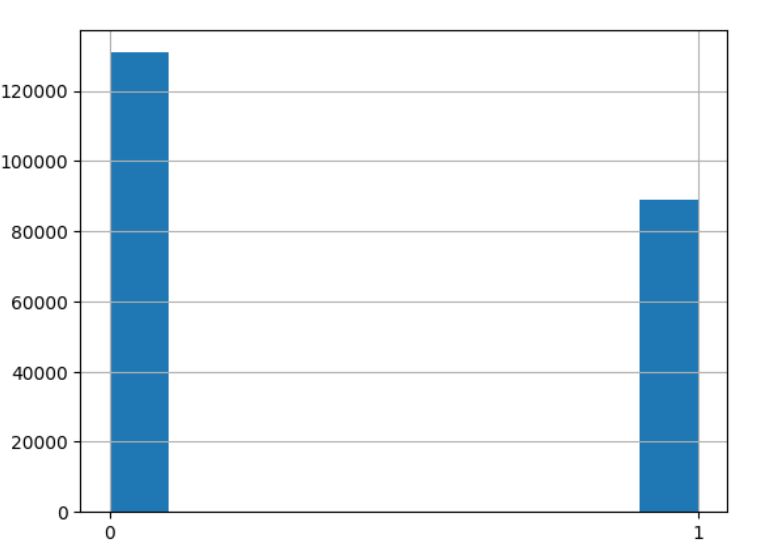

The dataset contains 220025 images, of which 89117 are malignant images.

In [ ]:
print(f'The dataset has {sum(labels_df.duplicated())} duplicates')

In [ ]:
fig = plt.figure(figsize=(25, 4))
path2data = "/kaggle/input/histopathologic-cancer-detection/train"
train_imgs = os.listdir(path2data)
for idx, img in enumerate(np.random.choice(train_imgs, 20)):
    ax = fig.add_subplot(2, 20//2, idx+1)
    im = Image.open(path2data + "/" + img)
    plt.imshow(im)
    lab = labels_df.loc[labels_df["id"] == img.split('.')[0], 'label'].values[0]
    ax.set_title(f'Label: {lab}')

# Data preprocess

In [ ]:
class cancer_dataset(Dataset):
    def __init__(self, data_dir, transform, data_type="train"):
        # path to images
        path2data = os.path.join(data_dir, data_type)
        
        # list of images in directory
        filenames = os.listdir(path2data)
        
        # get full path to images
        self.full_filenames = [os.path.join(path2data, f) for f in filenames]
        
        # get labels
        path2labels = os.path.join(data_dir, "train_labels.csv")
        labels_df = pd.read_csv(path2labels)
        
        # seg dataframe index to id
        labels_df.set_index("id", inplace=True)
        
        # obtain labels from df
        self.labels = [labels_df.loc[filename[:-4]].values[0] for filename in filenames]
        
        self.transform = transform
        
        
    def __len__(self):
        # return size of dataset
        return len(self.full_filenames)
    
    def __getitem__(self, idx):
        # open image, apply transforms and return with label
        img = Image.open(self.full_filenames[idx]) # PIL image
        img = self.transform(img)
        return img, self.labels[idx]

Create transformers to convert PIL image to PyTorch tensors

In [ ]:
data_transformer = transforms.Compose([transforms.ToTensor(),
                                       transforms.Resize((46,46))])

In [ ]:
data_dir = "/kaggle/input/histopathologic-cancer-detection"
img_dataset = cancer_dataset(data_dir, data_transformer, "train")

In [ ]:
img, label = img_dataset[19]
print(img.shape, torch.min(img), torch.max(img))

# Data split

In [ ]:
len_dataset = len(img_dataset)
len_train = int(0.8 * len_dataset)
len_val = len_dataset - len_train

train_ds, val_ds = random_split(img_dataset, [len_train, len_val])

print(f'train dataset length: {len(train_ds)}')
print(f'validation dataset length: {len(val_ds)}')

In [ ]:
i = 0
for x, y in train_ds:
    print(x.shape, y)
    i += 1
    if i > 5:
        break

# Transform image

In [ ]:
# transformer for trainging dataset
train_transf = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(45),
    transforms.RandomResizedCrop(96, scale=(0.8, 1.0), ratio=(1.0, 1.0)),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.ToTensor()
    ])

# No augmentation for validation dataset
val_transf = transforms.Compose([
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.ToTensor()
    ])

# Overwrite the transforms functions
train_ds.transform = train_transf
val_ds.transform = val_transf

In [ ]:
train_ds.transform

Create dataloaders

In [ ]:
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=False)

# check batches
for x, y in train_dl:
    print(x.shape)
    print(y.shape)
    break
    
for x, y in val_dl:
    print(x.shape)
    print(y.shape)
    break

# CNN model

In [ ]:
class Network(nn.Module):
    
    def __init__(self):
        
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3)
        self.conv4 = nn.Conv2d(32, 64, kernel_size=3)
        
        self.dropout_rate = 0.25
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(1*1*64, 100)
        self.fc2 = nn.Linear(100, 2)
        
    def forward(self, X):
        
        x = self.pool(F.relu(self.conv1(X)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        # flatten
        x = x.view(-1, 1*1*64)
        
        x = F.relu(self.fc1(x))
        x = F.dropout(x, self.dropout_rate)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
    
# create instant of model
cnn_model = Network()

# define hardware
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = cnn_model.to(device)
print(device)

summary(cnn_model, input_size=(3, 46, 46), device=device.type)

In [ ]:
m =torchvision.models.resnet50()
m.fc = nn.Linear(2048 , 2)
cnn_model = m

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = cnn_model.to(device)
print(device)

summary(cnn_model, input_size=(3, 46, 46), device=device.type)

Loss function

In [ ]:
loss_func = nn.NLLLoss(reduction="sum")

Optimiser

In [ ]:
opt = optim.Adam(cnn_model.parameters(), lr=3e-4)
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=20, verbose=0)

# Train

In [ ]:
# Function to get the learning rate
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

# Function to compute the loss value per batch of data
def loss_batch(loss_func, output, target, opt=None):
    
    loss = loss_func(output, target) # get loss
    pred = output.argmax(dim=1, keepdim=True) # Get Output Class
    metric_b=pred.eq(target.view_as(pred)).sum().item() # get performance metric
    
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

# Compute the loss value & performance metric for the entire dataset (epoch)
def loss_epoch(model,loss_func,dataset_dl,opt=None):
    
    run_loss=0.0 
    t_metric=0.0
    len_data=len(dataset_dl.dataset)

    # internal loop over dataset
    for xb, yb in tqdm(dataset_dl, leave=False):
        # move batch to device
        xb=xb.to(device)
        yb=yb.to(device)
        output=model(xb) # get model output
        loss_b,metric_b=loss_batch(loss_func, output, yb, opt) # get loss per batch
        run_loss+=loss_b        # update running loss

        if metric_b is not None: # update running metric
            t_metric+=metric_b    
    
    loss=run_loss/float(len_data)  # average loss value
    metric=t_metric/float(len_data) # average metric value
    
    return loss, metric

In [ ]:
from tqdm.notebook import trange, tqdm

def train_val(model, params, verbose=False):
    
    # Get parameters
    epochs = params["epochs"]
    opt = params["optimiser"]
    loss_func = params["f_loss"]
    train_dl = params["train"]
    val_dl = params["val"]
    lr_scheduler = params["lr_change"]
    weight_path = params["weight_path"]
    
    # history of loss and metric values in each epoch
    loss_history = {"train": [], "val": []}
    metric_history = {"train": [], "val": []}
    
    # a deep copy of weights for the best model
    best_model_wts = copy.deepcopy(model.state_dict())
    
    best_loss = float('inf')      # init loss
    
    # Train loop
    for epoch in tqdm(range(epochs), leave=False):
        
        # get lr
        current_lr = get_lr(opt)
        if(verbose):
            print(f'Epoch {epoch +1}/{epochs}, current lr={current_lr}')
        
        # train model
        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, opt)
        
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        
        # evaluate model
        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl)
        
        # store best model
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            
            # save weights in a local file
            torch.save(model.state_dict(), weight_path)
            if verbose:
                print("Saved best model weights")
            
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)
        
        # lr schedule
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            if verbose:
                print("Loading best model weights")
            model.load_state_dict(best_model_wts)
            
        if verbose:
            print(f"train loss: {train_loss:.6f}, dev loss: {val_loss:.6f}, accuracy: {100*val_metric:.2f}")
            print("-"*20)
            
    model.load_state_dict(best_model_wts)
    
    return model, loss_history, metric_history

In [ ]:
params_train={
 "train": train_dl,"val": val_dl,
 "epochs": 10,
 "optimiser": opt,
 "lr_change": lr_scheduler,
 "f_loss": loss_func,
 "weight_path": "weights.pt",
}

# Train model

model, loss_hist, metric_hist = train_val(model, params_train, verbose=True)

Loss and Metrics visual

In [ ]:
import seaborn as sns; sns.set(style='whitegrid')

epochs=params_train["epochs"]

fig,ax = plt.subplots(1,2,figsize=(12,5))

sns.lineplot(x=[*range(1,epochs+1)],y=loss_hist["train"],ax=ax[0],label='loss_hist["train"]')
sns.lineplot(x=[*range(1,epochs+1)],y=loss_hist["val"],ax=ax[0],label='loss_hist["val"]')
sns.lineplot(x=[*range(1,epochs+1)],y=metric_hist["train"],ax=ax[1],label='metric_hist["train"]')
sns.lineplot(x=[*range(1,epochs+1)],y=metric_hist["val"],ax=ax[1],label='metric_hist["val"]')
plt.title('Convergence History')

Classify the test dataset with trained model

In [ ]:
class cancerdata_test(Dataset):
    
    def __init__(self, data_dir, transform,data_type="train"):
        
        path2data = os.path.join(data_dir,data_type)
        filenames = os.listdir(path2data)
        self.full_filenames = [os.path.join(path2data, f) for f in filenames]
        
        # labels are in a csv file named train_labels.csv
        csv_filename="sample_submission.csv"
        path2csvLabels=os.path.join(data_dir,csv_filename)
        labels_df=pd.read_csv(path2csvLabels)
        
        # set data frame index to id
        labels_df.set_index("id", inplace=True)
        
        # obtain labels from data frame
        self.labels = [labels_df.loc[filename[:-4]].values[0] for filename in filenames]
        self.transform = transform       
        
    def __len__(self):
        # return size of dataset
        return len(self.full_filenames)
    
    def __getitem__(self, idx):
        # open image, apply transforms and return with label
        image = Image.open(self.full_filenames[idx]) # PIL image
        image = self.transform(image)
        return image, self.labels[idx]

In [ ]:
# load any model weights for the model
model.load_state_dict(torch.load('weights.pt'))

In [ ]:
path2sub = "/kaggle/input/histopathologic-cancer-detection/sample_submission.csv"
labels_df = pd.read_csv(path2sub)
data_dir = '/kaggle/input/histopathologic-cancer-detection/'

data_transformer = transforms.Compose([transforms.ToTensor(),
                                       transforms.Resize((46,46))])

img_dataset_test = cancerdata_test(data_dir,data_transformer,data_type="test")
print(len(img_dataset_test), 'samples found')

In [ ]:
def inference(model,dataset,device,num_classes=2):
    
    len_data=len(dataset)
    y_out=torch.zeros(len_data,num_classes) # initialize output tensor on CPU
    y_gt=np.zeros((len_data),dtype="uint8") # initialize ground truth on CPU
    model=model.to(device) # move model to device
    model.eval()
    
    with torch.no_grad():
        for i in tqdm(range(len_data)):
            x,y=dataset[i]
            y_gt[i]=y
            y_out[i]=model(x.unsqueeze(0).to(device))

    return y_out.numpy(),y_gt           

y_test_out,_ = inference(model,img_dataset_test, device)  
y_test_pred=np.argmax(y_test_out,axis=1)

test_ids = [name.split('/')[-1].split('.')[0] for name in img_dataset_test.full_filenames]
test_preds = pd.DataFrame({"img": test_ids, "preds": y_test_pred})
submission = pd.merge(labels_df, test_preds, left_on='id', right_on='img')
submission = submission[['id', 'preds']]
submission.columns = ['id', 'label']
submission.head()

In [ ]:
submission.to_csv('submission.csv', index=False)

In [ ]:
images = '../input/histopathologic-cancer-detection/train/' 

draw_category_images('label',4, df_data, images)

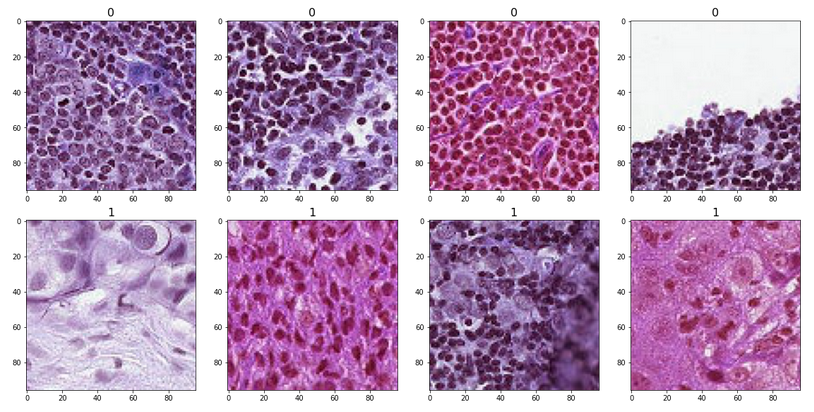